# Complete workflow to get info from GIS tools for hydrological modelling

Here we use birdy's WPS client to perform a catchment delineation, use the delineation to extract physical properties and prepare data for hydrological modelling, all using the Raven server.

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

url = "http://localhost:9099/wps"
wps = WPSClient(url, progress=True)

In [8]:
# MANIC: lonlat_coordinate="(-68.724444, 50.646667)"
r_select = wps.shape_selection(location="-75.724444, 44.646667",lakes=True, aggregate_upstream=True)

The `location` parameter identifies the outlet of the watershed, and `aggregate_upstream` determines whether or not we want the service to return all upstream basins. 

In [10]:
# Get JSON Polygons of the delineated catchment
[features, upstream_basins] = r_select.get(asobj=True)
feature = features['features'][0] # TODO: Fix this server-side

Now that we have delineated a catchment, lets find the zonal statistics and other properties of the catchment.

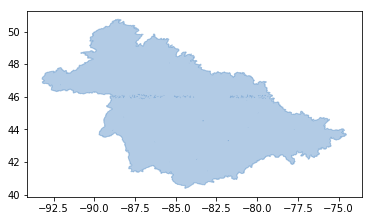

In [11]:
from descartes import PolygonPatch
import matplotlib.pyplot as plt 

BLUE = '#6699cc'
fig = plt.figure() 
ax = fig.gca() 
ax.add_patch(PolygonPatch(feature['geometry'], fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
ax.axis('scaled')
plt.show()


In [12]:
# Here we are using the geojson file created on the server in the last step as the input value to a process 
# computing watershed properties. 
#crs=4326
#projected_crs=32198
[features, upstream_basins] = r_select.get()
resp = wps.shape_properties(shape=features)

In [13]:
[properties]=resp.get(asobj=True)
print(properties)

[{'id': '7120034520', 'COAST': 0, 'DIST_MAIN': 500.1, 'DIST_SINK': 500.1, 'ENDO': 0, 'HYBAS_ID': 7121021261, 'LAKE': 1209, 'NEXT_DOWN': 7120421412, 'NEXT_SINK': 7120034520, 'ORDER': 1, 'PFAF_ID': 725510701200, 'SIDE': 'L', 'SORT': 99271, 'SUB_AREA': 766237.7, 'UP_AREA': 766270.4, 'area': 772095248092.3353, 'centroid': [-84.31996604288439, 45.16993914390546], 'perimeter': 9807568.183716247, 'gravelius': 3.148625180402048}]


Note that these properties are a mix of the properties of the original file where the shape is stored, and properties computed by the process (area, centroid, perimeter and gravelius). Note also that the computed area is in m², while the "SUB_AREA" property is in km², and that there are differences between the two values. 

## Now, Let's extract Zonal Stats. Again, can't use the asobj=true, so we use False and then I am stuck with the  problem that the results are behind a link I can't seem to access.

Yeah, same problem server-side... 

In [19]:
# This should be a GeoServer link to the full raster
raster=TESTDATA['earthenv_dem_90m']
resp = wps.zonal_stats(features, str(raster), select_all_touching=True,return_geojson=False)

In [17]:
statistics=resp.get(asobj=True)

In [18]:
statistics

zonal_statsResponse(
    statistics=[{'count': 0, 'min': None, 'max': None, 'mean': None, 'median': None, 'sum': None, 'nodata': 126749249.0}]
)

This does not work because the test DEM does not cover the basin of interest. Here we need to go back to the process and set as a default DEM the North American DEM Trevor uploaded to Geoserver. On my list. 

# NEED TO ADD LAND COVER AND SLOPE EXTRACTIONS, BUT THIS IS A GOOD START!